# Deep learning-based automated rock classification via high-resolution drone-captured core sample imagery
***
### Domenico M. Crisafulli, Misael M. Morales, and Carlos Torres-Verdin
#### The University of Texas at Austin, 2024
***

## Build and Train NN-classifier
| Class             | OLD   | New   |
| ---               | ---   | ---   |
| Background        | 0     | 0     |
| Sandstone type 1  | 1     | 2     |
| Shaly Rock        | 2     | 3     |
| Sandstone type 2  | 3     | 4     |
| Carbonate         | 4     | 5     |
| Shale             | 5     | 6     |
| Sandstone type 3  | 6     | 7     |
| Box               | 10    | 1     |

In [3]:
import os
from time import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image
import scipy.io as sio

import tensorflow as tf
import keras
from keras import Model
from keras import layers, losses, optimizers, activations
from keras.applications.resnet import ResNet50, preprocess_input

def check_tf_gpu(verbose:bool=True):
    sys_info = tf.sysconfig.get_build_info()
    version, cuda, cudnn = tf.__version__, sys_info["cuda_version"], sys_info["cudnn_version"]
    count = len(tf.config.experimental.list_physical_devices())
    name  = [device.name for device in tf.config.experimental.list_physical_devices('GPU')]
    if verbose:
        print('-'*60)
        print('----------------------- VERSION INFO -----------------------')
        print('TF version: {} | # Device(s) available: {}'.format(version, count))
        print('TF Built with CUDA? {} | CUDA: {} | cuDNN: {}'.format(tf.test.is_built_with_cuda(), cuda, cudnn))
        print(tf.config.list_physical_devices()[0],'\n', tf.config.list_physical_devices()[1])
        print('-'*60+'\n')
    return None

check_tf_gpu()

------------------------------------------------------------
----------------------- VERSION INFO -----------------------
TF version: 2.16.1 | # Device(s) available: 2
TF Built with CUDA? True | CUDA: 12.0 | cuDNN: 8
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU') 
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
------------------------------------------------------------



In [4]:
def patch_image(input_image, patch_h=252, patch_w=252, pad=4, channel_axis=-1):
    if channel_axis is not None:
        h, w, c = input_image.shape
    else:
        h, w = input_image.shape
    patches = []
    for i in range(0, h, patch_h):
        for j in range(0, w, patch_w):
            if channel_axis is not None:
                patch = input_image[i:i+patch_h, j:j+patch_w, :]
                patch = np.pad(patch, ((pad,pad),(pad,pad),(0,0)))
            else:
                patch = input_image[i:i+patch_h, j:j+patch_w]
                patch = np.pad(patch, ((pad,pad),(pad,pad)))
            patches.append(patch)
    return np.array(patches)

In [5]:
x_names_pictures = []
for root, dirs, files in os.walk('data'):
    for f in files:
        if (f.endswith('.jpg') or f.endswith('.JPG')) and f.startswith('DJI'):
            x_names_pictures.append(os.path.join(root, f))

y_names_masks = []
for root, dirs, files in os.walk('data'):
    for file in files:
        if file.endswith('.mat') and file.startswith('img_'):
            y_names_masks.append(os.path.join(root, file))

In [6]:
x_pictures = []
y_masks    = []
for i in tqdm(range(len(x_names_pictures)), desc='Loading images'):
    y = sio.loadmat(y_names_masks[i],simplify_cells=True)
    if 'AA' in y.keys():
        y_masks.append(y['AA'])
        x = np.array(Image.open(x_names_pictures[i]).convert('RGB'))
        x_pictures.append(x)

X_data = np.array(x_pictures)
y_data = np.array(y_masks)
print(X_data.shape, y_data.shape)

Loading images: 100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


(15, 3024, 4032, 3) (15, 3024, 4032)


In [7]:
IMAGE_SIZE = 504
PADDING = 4
PADDED_IMAGE = IMAGE_SIZE+PADDING*2

x_data_patched = []
y_data_patched = []
for i in tqdm(range(X_data.shape[0]), desc='Patching images'):
    x = patch_image(X_data[i], patch_h=IMAGE_SIZE, patch_w=IMAGE_SIZE, pad=PADDING)
    x_data_patched.append(x)
    y = patch_image(y_data[i], patch_h=IMAGE_SIZE, patch_w=IMAGE_SIZE, pad=PADDING, channel_axis=None)
    y_data_patched.append(y)
    
x_data_patched = np.array(x_data_patched).reshape(-1, PADDED_IMAGE, PADDED_IMAGE, 3)
y_data_patched = np.array(y_data_patched).reshape(-1, PADDED_IMAGE, PADDED_IMAGE, 1)
print(x_data_patched.shape, y_data_patched.shape)

Patching images: 100%|██████████| 15/15 [00:00<00:00, 66.37it/s]


(720, 512, 512, 3) (720, 512, 512, 1)


In [94]:
idx = []
for i in tqdm(range(y_data_patched.shape[0]), desc='Nonzero Filter'):
    m = y_data_patched[i]
    p = np.sum(m)
    if p > 5e3:
        idx.append(i)

x_data_nonzero = x_data_patched[idx].astype(np.float32)
y_data_nonzero = y_data_patched[idx].astype(np.uint8)
print(x_data_nonzero.shape, y_data_nonzero.shape)

Nonzero Filter: 100%|██████████| 720/720 [00:00<00:00, 10472.71it/s]


(278, 512, 512, 3) (278, 512, 512, 1)


In [95]:
rand_idx = np.random.choice(x_data_nonzero.shape[0], size=x_data_nonzero.shape[0], replace=False)
n_train = 250

X_train = x_data_nonzero[rand_idx[:n_train]]/255
y_train = y_data_nonzero[rand_idx[:n_train]]

X_test = x_data_nonzero[rand_idx[n_train:]]/255
y_test = y_data_nonzero[rand_idx[n_train:]]

y_train[y_train==255] = 5
y_test[y_test==255] = 5

print('X - train: {} | test: {}'.format(X_train.shape, X_test.shape))
print('y - train: {} | test: {}'.format(y_train.shape, y_test.shape))
print('Labels - train: {} | test: {}'.format(np.unique(y_train), np.unique(y_test)))

X - train: (250, 512, 512, 3) | test: (28, 512, 512, 3)
y - train: (250, 512, 512, 1) | test: (28, 512, 512, 1)
Labels - train: [0 1 2 3 4 5 6] | test: [0 1 2 4 5]


In [124]:
nlabels = len(np.unique(y_train))

y_train_masked = np.zeros((y_train.shape[0], 512, 512, nlabels))
y_test_masked  = np.zeros((y_test.shape[0], 512, 512, nlabels))

for i in tqdm(range(nlabels), desc='One-Hot Encoding labels'):
    y_train_masked[...,i] = (y_train[...,0]==i).astype(np.uint8)
    y_test_masked[...,i]  = (y_test[...,0]==i).astype(np.uint8)
print('y masked - train: {} | test: {}'.format(y_train_masked.shape, y_test_masked.shape))

One-Hot Encoding labels: 100%|██████████| 7/7 [00:02<00:00,  3.30it/s]

y masked - train: (250, 512, 512, 7) | test: (28, 512, 512, 7)


In [ ]:
fig, axs = plt.subplots(2, 15, figsize=(25,4), sharex=True, sharey=True)
for j in range(15):
    ax1, ax2 = axs[0,j], axs[1,j]
    ax1.imshow(X_train[j])
    ax2.imshow(y_train[j])
plt.tight_layout()
plt.show()

In [143]:
class MonitorCallback(keras.callbacks.Callback):
    def __init__(self, monitor:int=10):
        super(MonitorCallback, self).__init__()
        self.monitor = monitor
    
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % self.monitor == 0:
            print('Epoch: {} | Accuracy: {:.3f} | Loss: {:.3e}'.format(epoch+1, logs['accuracy'], logs['loss']))

In [144]:
def CoreSegNet(image_size:int=512, in_channels:int=3, out_channels:int=1):
    
    def convolution_block(inp, num_filters, kernel_size=3):
        _ = layers.SeparableConv2D(num_filters, kernel_size=kernel_size, padding="same")(inp)
        _ = layers.GroupNormalization(num_filters)(_)
        _ = activations.gelu(_)
        return _
    
    # Encoder
    input = layers.Input(shape=(image_size, image_size, in_channels))
    x = convolution_block(input, 16)
    x = layers.MaxPooling2D(2)(x)
    f1 = x
    x = convolution_block(x, 64)
    x = layers.MaxPooling2D(2)(x)
    f2 = x
    x = convolution_block(x, 256)
    x = layers.MaxPooling2D(2)(x)
    f3 = x
    
    # Decoder
    x = layers.concatenate([x, f3])
    x = convolution_block(x, 256)
    x = layers.Conv2DTranspose(64, 2, 2, padding='same')(x)

    x = layers.concatenate([x, f2])
    x = convolution_block(x, 64)
    x = layers.Conv2DTranspose(16, 2, 2, padding='same')(x)

    x = layers.concatenate([x, f1])
    x = convolution_block(x, 16)
    x = layers.Conv2DTranspose(out_channels, 2, 2, padding='same')(x)

    output = layers.Conv2D(out_channels, 1, 1, activation='softmax')(x)
    
    return Model(inputs=input, outputs=output)

In [ ]:
def CustomLoss(true, pred, alpha=0.75):
    cce = losses.categorical_crossentropy(true, pred)
    ssim = tf.reduce_mean(1 - tf.image.ssim_multiscale(true, pred, max_val=1.0))
    return alpha*cce + (1-alpha)*ssim

In [145]:
model = CoreSegNet(image_size=512, out_channels=7)
print('# parameters: {:,}'.format(model.count_params())+'\n'+'-'*30)

optimizer = optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)
criterion = losses.CategoricalCrossentropy()
callbacks = [MonitorCallback(monitor=10)]
model.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy', 'mse'])

start = time()
fit = model.fit(X_train, y_train_masked,
                batch_size       = 8, 
                epochs           = 201, 
                validation_split = 0.2,
                shuffle          = True,
                verbose          = 0,
                callbacks        = [callbacks])
print('-'*30+'\n'+'Training time: {:.2f} minutes'.format((time()-start)/60))
model.save('CoreSegNet.keras')
pd.DataFrame(fit.history).to_csv('CoreSegNet_history.csv', index=False)

# parameters: 1,488,671
------------------------------
Epoch: 10 | Accuracy: 0.673 | Loss: 9.128e-01
Epoch: 20 | Accuracy: 0.721 | Loss: 8.016e-01
Epoch: 30 | Accuracy: 0.735 | Loss: 7.183e-01
Epoch: 40 | Accuracy: 0.741 | Loss: 7.002e-01
Epoch: 50 | Accuracy: 0.784 | Loss: 5.992e-01
Epoch: 60 | Accuracy: 0.774 | Loss: 6.097e-01
Epoch: 70 | Accuracy: 0.763 | Loss: 6.545e-01
Epoch: 80 | Accuracy: 0.788 | Loss: 5.669e-01
Epoch: 90 | Accuracy: 0.799 | Loss: 5.362e-01
Epoch: 100 | Accuracy: 0.800 | Loss: 5.335e-01
Epoch: 110 | Accuracy: 0.798 | Loss: 5.382e-01
Epoch: 120 | Accuracy: 0.784 | Loss: 5.623e-01
Epoch: 130 | Accuracy: 0.817 | Loss: 4.813e-01
Epoch: 140 | Accuracy: 0.813 | Loss: 4.896e-01
Epoch: 150 | Accuracy: 0.823 | Loss: 4.634e-01
Epoch: 160 | Accuracy: 0.820 | Loss: 4.668e-01
Epoch: 170 | Accuracy: 0.826 | Loss: 4.514e-01
Epoch: 180 | Accuracy: 0.827 | Loss: 4.529e-01
Epoch: 190 | Accuracy: 0.822 | Loss: 4.855e-01
Epoch: 200 | Accuracy: 0.828 | Loss: 4.388e-01
Epoch: 210 | A

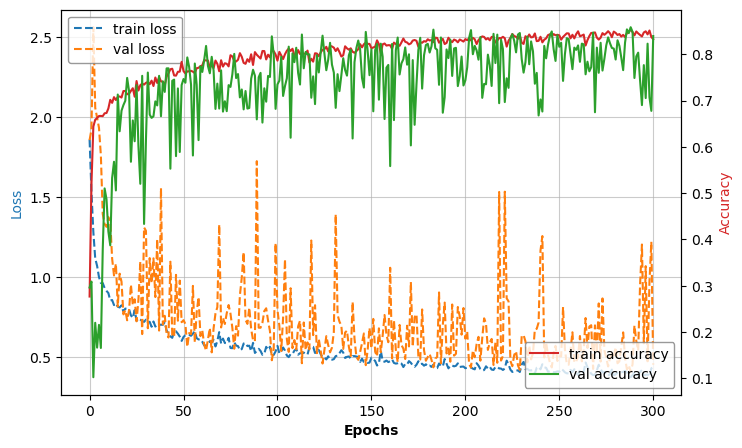

In [149]:
fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.plot(fit.history['loss'],         ls='--', label='train loss',     color='tab:blue')
ax1.plot(fit.history['val_loss'],     ls='--', label='val loss',       color='tab:orange')
ax2.plot(fit.history['accuracy'],     ls='-',  label='train accuracy', color='tab:red')
ax2.plot(fit.history['val_accuracy'], ls='-',  label='val accuracy',   color='tab:green')
ax1.set_xlabel('Epochs', weight='bold')
ax1.set_ylabel('Loss', color='tab:blue')
ax2.set_ylabel('Accuracy', color='tab:red')
ax1.grid(True, which='both', alpha=0.66)
ax1.legend(loc='upper left', edgecolor='gray')
ax2.legend(loc='lower right', edgecolor='gray')
plt.show()

In [168]:
y_train_pred = model.predict(X_train[:15], verbose=0)
y_test_pred  = model.predict(X_test[:15], verbose=0)
print('Pred - train: {} | test: {}'.format(y_train_pred.shape, y_test_pred.shape))

Pred - train: (15, 512, 512, 7) | test: (15, 512, 512, 7)


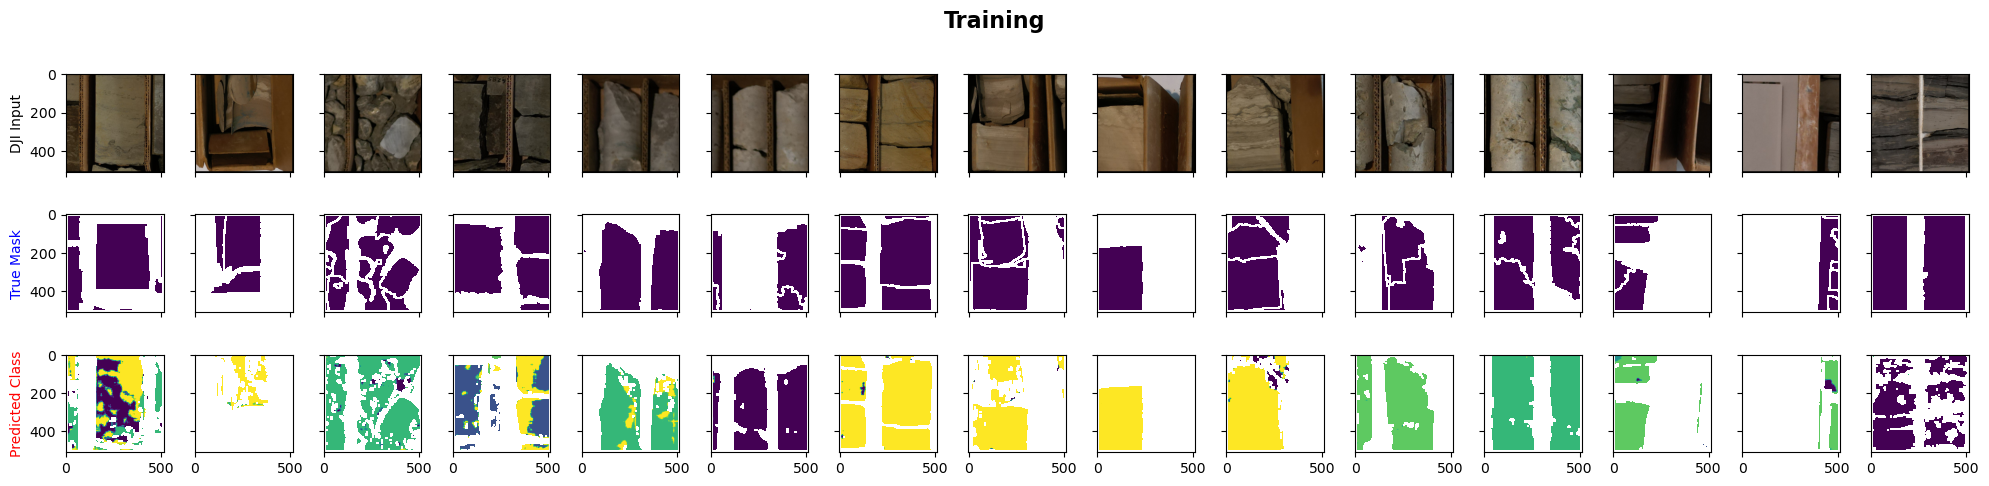

In [169]:
labels = ['DJI Input', 'True Mask', 'Predicted Class']
colors = ['black','blue','red']
fig, axs = plt.subplots(3, 15, figsize=(20,5), sharex=True, sharey=True)

for j in range(15):
    ax1, ax2, ax3 = axs[0,j], axs[1,j], axs[2,j]
    ax1.imshow(X_train[j])

    true = y_train_masked[j].argmax(-1)
    pred = y_train_pred[j].argmax(-1)

    dt = np.ma.masked_where(true==0, true)
    dp = np.ma.masked_where(pred==0, pred)

    ax2.imshow(dt)
    ax3.imshow(dp)

    [a.set_ylabel(labels[k], color=colors[k]) for k,a in enumerate([ax1,ax2,ax3])] if j==0 else None

fig.suptitle('Training', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

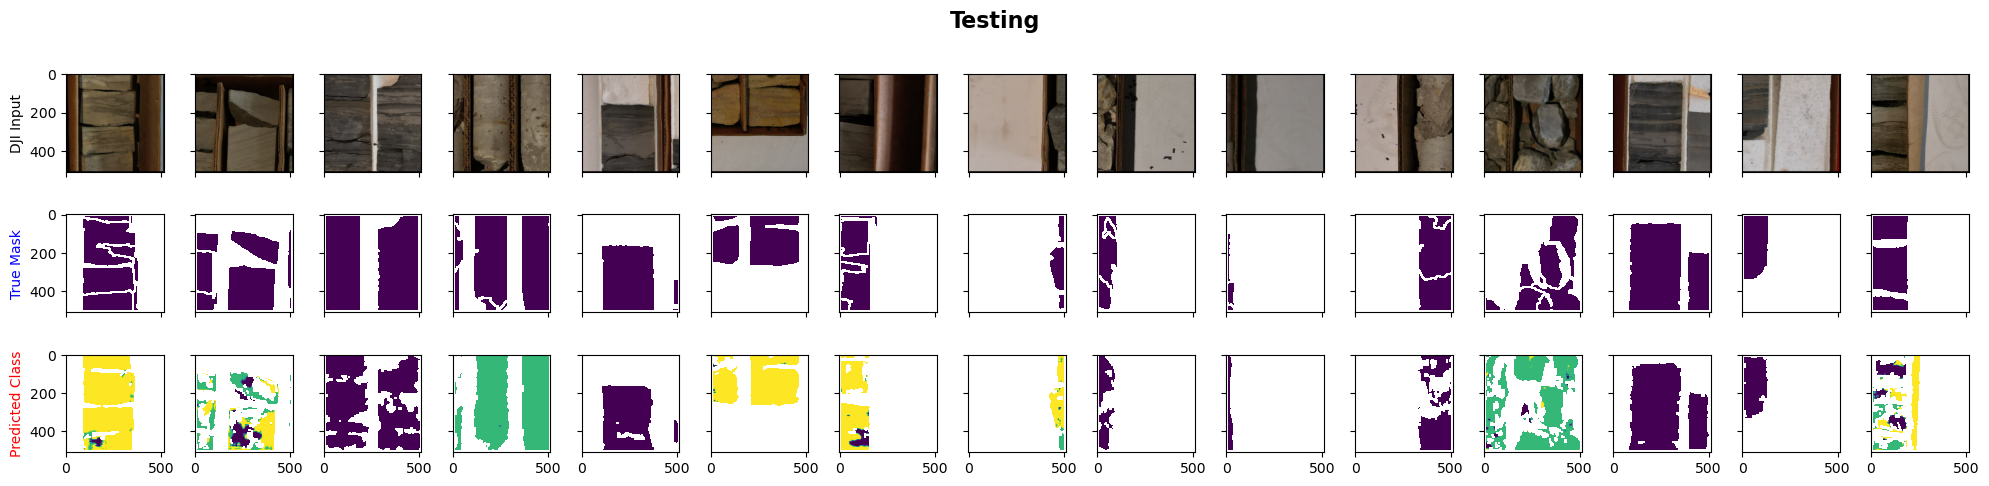

In [170]:
labels = ['DJI Input', 'True Mask', 'Predicted Class']
colors = ['black','blue','red']
fig, axs = plt.subplots(3, 15, figsize=(20,5), sharex=True, sharey=True)

for j in range(15):
    ax1, ax2, ax3 = axs[0,j], axs[1,j], axs[2,j]
    ax1.imshow(X_test[j])

    true = y_test_masked[j].argmax(-1)
    pred = y_test_pred[j].argmax(-1)

    dt = np.ma.masked_where(true==0, true)
    dp = np.ma.masked_where(pred==0, pred)

    ax2.imshow(dt)
    ax3.imshow(dp)

    [a.set_ylabel(labels[k], color=colors[k]) for k,a in enumerate([ax1,ax2,ax3])] if j==0 else None

fig.suptitle('Testing', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

***
# END